# Programming Assignment 3: Sentiment analysis

In this programming assignment, you will implement logistic regression to predict the sentiment of reviews that come from `imdb.com`, `amazon.com`, and `yelp.com`. Make sure the notebook is in the same folder that contains `full_set.txt`.

## 1. Load and preprocess data

In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). To be consistent with our notation from lecture, we will change the negative review label to '-1'.

In [2]:
## Read in the data set.
with open("full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

for i in range(5):
    print ('Label: ',y[i],'; ', sentences[i])

Label:  -1 ;  So there is no way for me to plug it in here in the US unless I go by a converter.
Label:  1 ;  Good case, Excellent value.
Label:  1 ;  Great for the jawbone.
Label:  -1 ;  Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
Label:  1 ;  The mic is great.


### Preprocessing the text data

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. We will do four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

We begin with first two steps.

In [3]:
## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have put together a very small list of stop words, but these are by no means comprehensive. Feel free to use something different; for instance, larger lists can easily be found on the web.

In [4]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

What do the sentences look like so far?

In [5]:
sents_processed[0:10]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great',
 'have jiggle plug get line up right get decent volume',
 'if you have several dozen or several hundred contacts then imagine fun sending each them one by one',
 'if you are razr owner you must have this',
 'needless say wasted my money',
 'what waste money and time']

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. In this representation, each word is thought of as corresponding to a number in `{1, 2, ..., d}` where `d` is the size of our vocabulary. And each sentence is represented as a d-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.

To do this transformation, we will make use of the `CountVectorizer` class in `scikit-learn` (Note that this is the only time you can call an external function from scikit-learn). We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

**Task P1:** Once you get the bag-of-words representation, append a '1' to the beginning of each vector to allow our linear classifier to learn a bias term. What is the size of the resulting data_mat matrix?

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)
print ('The original size: ',data_features.shape)

The original size:  (3000, 4500)


In [7]:
## STUDENT: YOUR CODE STARTS HERE
# Task: Append '1' to the beginning of each vector.
# Hint: You can use data_features.toarray() to transform data_features into a numpy array
# The output should be a numpy array named data_mat


data_mat = data_features.toarray()# please assign a numpy array to this
data_mat = np.insert(data_mat, 0, 1, axis = 1)

## STUDENT: CODE ENDS
print ('The updated size: ',data_mat.shape)
print(data_mat)

The updated size:  (3000, 4501)
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


### Training / test split

Finally, we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [8]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4501)
test data:  (500, 4501)


## 2. Fitting a logistic regression model to the training data

In this section, we will implement our own logistic regression solver using gradient descent. As we have seen in the class, to learn the parameters of logistic regression, we need to perform the following optimization:

$$
{\bf \tilde\theta}_t =
\underset{{\bf \tilde\theta}}{\operatorname{argmin}} \; L_\mathcal{D}({\bf \tilde\theta}) =
\underset{{\bf \tilde\theta}}{\operatorname{argmin}} \;\sum_{i=1}^{n} \ln \left( 1 + e^{y_i \; {\bf \tilde\theta}_t^T {\tilde x}_i} \right)
$$
where $y_i\in\{-1,+1\}$ is the label, ${\bf \tilde\theta}$ is the vector of coefficients:
$$
{\bf \tilde\theta} = \begin{bmatrix} \theta_0 & \theta_1 & ... & \theta_d \end{bmatrix}^T,
$$
and ${\tilde x}$ is the "augmented" feature vector (of $d+1$ dimensions), where we stick a 1 in the front of the original features:
$$
{\tilde x} = \begin{bmatrix} 1 & x_1 & ... & x_d \end{bmatrix}^T.
$$


There is no nice, closed-form solution like with [least-squares linear regression](http://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse) so we will use [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) instead. Specifically we will use batch gradient descent which calculates the gradient from all data points in the data set. Luckily, the loss function $L_\mathcal{D}({\bf \tilde\theta})$ we want to minimize is [convex](http://en.wikipedia.org/wiki/Convex_optimization) so there is only one minimum. Thus the minimum we arrive at is the global minimum.

Gradient descent is a general method and requires twice differentiability for [smoothness](http://en.wikipedia.org/wiki/Smooth_function). It updates the parameters using a first-order approximation of the error surface.

$$
{\bf \tilde\theta}_{t+1} = {\bf \tilde\theta}_t + \nabla L_\mathcal{D}({\bf \tilde\theta}_t)
$$

**Task P2:** Derive the gradient of the loss $L_\mathcal{D}({\bf \tilde\theta})$ with respect to ${\bf \tilde\theta}$, namely $\nabla L_\mathcal{D}({\bf \tilde\theta}_t)$. The answer should depend on data points $(x_i,y_i)$ for $i=1,...,n$, and the model parameter ${\bf \tilde\theta}$. Make sure you get the sign correct. Also implement the function `weight_derivative`. Print the output of the code. 

In [21]:
def weight_derivative(weights, feature_matrix, labels):
    # Input:
    # weights: weight vector w, a numpy vector of dimension d
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d, each with value -1 or +1
    # Output:
    # Derivative of the regression cost function with respect to the weight w, a numpy array of dimension d
        
    ## STUDENT: Start of code ###
    y = labels
    theta = weights
    total = np.zeros(4501)
    
    for i in range(train_labels.size):
        x = feature_matrix[i,]
        d = np.dot(x, theta)
        powr = -(y[i]*d)
        exp = np.exp(powr)
        du = -(y[i]*x)
        numerator = du * exp
        denominator = 1 + exp
        result = numerator / denominator
        total = np.add(total, result)
        
    derivative = total
        
    return derivative
    # End of code ###

In [22]:
# STUDENT: PRINT THE OUTPUT AND COPY IT TO THE SOLUTION FILE
my_weights = np.ones(data_mat.shape[1]) # a weight of all 1s
derivative = weight_derivative(my_weights,train_data,train_labels)

print (derivative[:10])

[ 1.23415330e+03 -4.13993755e-08  1.00000000e+00  9.99993856e-01
  1.99987630e+00  9.99859072e-01  9.52574127e-01  3.59772270e+01
  2.99996572e+00 -1.38879439e-11]


Now, we can just use the same gradient descent algorithm that we wrote in assignment 2 to solve it.

In [23]:
def gradient_descent(feature_matrix, labels, initial_weights, step_size, tolerance):
    # Gradient descent algorithm for logistic regression problem    
    
    # Input:
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # initial_weights: initial weight vector to start with, a numpy vector of dimension d
    # step_size: step size of update
    # tolerance: tolerace epsilon for stopping condition
    # Output:
    # Weights obtained after convergence

    converged = False 
    weights = np.array(initial_weights) # current iterate
    i = 0
    while not converged:
        # impelementation of what the gradient descent algorithm does in every iteration
        # Refer back to the update rule listed above: update the weight
        i += 1
        derivative = weight_derivative(weights, feature_matrix, labels)
        
        weights -= (step_size * derivative)
        
        # Compute the gradient magnitude:
        
        gradient_magnitude = np.sqrt(np.sum(derivative**2))
        
        # Check the stopping condition to decide whether you want to stop the iterations
        # print ("grad mag :", gradient_magnitude)
        #print ("tolerance:", tolerance)
        
        if gradient_magnitude < tolerance:
            converged = True
        
        print ("Iteration: ",i,"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        
    return(weights)

**Task P3:** Specify the initial_weights, step_size, and tolerance for the function `gradient_descent`. Copy the outputs of the code to the solution file.

In [24]:
#Initialize the weights, step size and tolerance
# Start of code
#STUDENT: Specify the initial_weights, step_size, and tolerance
initial_weights = np.zeros(data_mat.shape[1])
step_size = 2e-3
tolerance = 3
# end of code

# Use the regression_gradient_descent function to calculate the gradient decent and store it in the variable 'final_weights'
final_weights = gradient_descent(train_data,train_labels, initial_weights, step_size, tolerance)

# end of code
print ("Here are the final weights after convergence:")
print (final_weights)

Iteration:  1 gradient_magnitude:  209.21400526733385
Iteration:  2 gradient_magnitude:  178.58496774522143
Iteration:  3 gradient_magnitude:  159.8927105443988
Iteration:  4 gradient_magnitude:  146.5002270747251
Iteration:  5 gradient_magnitude:  135.9075180968014
Iteration:  6 gradient_magnitude:  127.0278241564014
Iteration:  7 gradient_magnitude:  119.3903556928941
Iteration:  8 gradient_magnitude:  112.78860450244265
Iteration:  9 gradient_magnitude:  107.07175483158811
Iteration:  10 gradient_magnitude:  102.14167671861115
Iteration:  11 gradient_magnitude:  97.88114002614333
Iteration:  12 gradient_magnitude:  94.1895353928877
Iteration:  13 gradient_magnitude:  90.96299842429494
Iteration:  14 gradient_magnitude:  88.11614643193525
Iteration:  15 gradient_magnitude:  85.57490653621652
Iteration:  16 gradient_magnitude:  83.28272066484196
Iteration:  17 gradient_magnitude:  81.19486432128949
Iteration:  18 gradient_magnitude:  79.2781651740734
Iteration:  19 gradient_magnitude:

Iteration:  152 gradient_magnitude:  29.61630080604684
Iteration:  153 gradient_magnitude:  29.51361579405536
Iteration:  154 gradient_magnitude:  29.411853083430547
Iteration:  155 gradient_magnitude:  29.310998713790713
Iteration:  156 gradient_magnitude:  29.211039022158626
Iteration:  157 gradient_magnitude:  29.111960634820235
Iteration:  158 gradient_magnitude:  29.01375045945506
Iteration:  159 gradient_magnitude:  28.916395677527568
Iteration:  160 gradient_magnitude:  28.819883736929285
Iteration:  161 gradient_magnitude:  28.724202344861887
Iteration:  162 gradient_magnitude:  28.629339460952075
Iteration:  163 gradient_magnitude:  28.53528329058921
Iteration:  164 gradient_magnitude:  28.44202227847729
Iteration:  165 gradient_magnitude:  28.3495451023931
Iteration:  166 gradient_magnitude:  28.257840667142826
Iteration:  167 gradient_magnitude:  28.166898098709613
Iteration:  168 gradient_magnitude:  28.07670673858503
Iteration:  169 gradient_magnitude:  27.98725613827762
I

Iteration:  300 gradient_magnitude:  20.259836655542742
Iteration:  301 gradient_magnitude:  20.22009901688097
Iteration:  302 gradient_magnitude:  20.180548613424772
Iteration:  303 gradient_magnitude:  20.141183980895804
Iteration:  304 gradient_magnitude:  20.102003671235074
Iteration:  305 gradient_magnitude:  20.063006252372052
Iteration:  306 gradient_magnitude:  20.024190307997838
Iteration:  307 gradient_magnitude:  19.985554437342206
Iteration:  308 gradient_magnitude:  19.94709725495456
Iteration:  309 gradient_magnitude:  19.90881739048862
Iteration:  310 gradient_magnitude:  19.870713488490814
Iteration:  311 gradient_magnitude:  19.832784208192326
Iteration:  312 gradient_magnitude:  19.79502822330462
Iteration:  313 gradient_magnitude:  19.757444221818506
Iteration:  314 gradient_magnitude:  19.720030905806567
Iteration:  315 gradient_magnitude:  19.68278699122896
Iteration:  316 gradient_magnitude:  19.645711207742433
Iteration:  317 gradient_magnitude:  19.6088022985126

Iteration:  448 gradient_magnitude:  15.86118243091672
Iteration:  449 gradient_magnitude:  15.838867754235944
Iteration:  450 gradient_magnitude:  15.816625812797213
Iteration:  451 gradient_magnitude:  15.794456225601882
Iteration:  452 gradient_magnitude:  15.772358614481774
Iteration:  453 gradient_magnitude:  15.75033260407153
Iteration:  454 gradient_magnitude:  15.728377821781276
Iteration:  455 gradient_magnitude:  15.706493897769617
Iteration:  456 gradient_magnitude:  15.684680464916958
Iteration:  457 gradient_magnitude:  15.662937158799137
Iteration:  458 gradient_magnitude:  15.641263617661362
Iteration:  459 gradient_magnitude:  15.619659482392477
Iteration:  460 gradient_magnitude:  15.598124396499502
Iteration:  461 gradient_magnitude:  15.576658006082504
Iteration:  462 gradient_magnitude:  15.555259959809735
Iteration:  463 gradient_magnitude:  15.533929908893086
Iteration:  464 gradient_magnitude:  15.5126675070638
Iteration:  465 gradient_magnitude:  15.491472410548

Iteration:  595 gradient_magnitude:  13.205175464884288
Iteration:  596 gradient_magnitude:  13.190548454893822
Iteration:  597 gradient_magnitude:  13.175958592535359
Iteration:  598 gradient_magnitude:  13.161405728888061
Iteration:  599 gradient_magnitude:  13.146889715849989
Iteration:  600 gradient_magnitude:  13.132410406132202
Iteration:  601 gradient_magnitude:  13.117967653252938
Iteration:  602 gradient_magnitude:  13.103561311531813
Iteration:  603 gradient_magnitude:  13.089191236084107
Iteration:  604 gradient_magnitude:  13.074857282815074
Iteration:  605 gradient_magnitude:  13.060559308414323
Iteration:  606 gradient_magnitude:  13.046297170350243
Iteration:  607 gradient_magnitude:  13.032070726864463
Iteration:  608 gradient_magnitude:  13.017879836966394
Iteration:  609 gradient_magnitude:  13.003724360427787
Iteration:  610 gradient_magnitude:  12.989604157777364
Iteration:  611 gradient_magnitude:  12.975519090295476
Iteration:  612 gradient_magnitude:  12.96146902

Iteration:  742 gradient_magnitude:  11.389095840667864
Iteration:  743 gradient_magnitude:  11.3786689090257
Iteration:  744 gradient_magnitude:  11.368263725338755
Iteration:  745 gradient_magnitude:  11.357880217617382
Iteration:  746 gradient_magnitude:  11.34751831419268
Iteration:  747 gradient_magnitude:  11.337177943714682
Iteration:  748 gradient_magnitude:  11.326859035150552
Iteration:  749 gradient_magnitude:  11.316561517782786
Iteration:  750 gradient_magnitude:  11.306285321207445
Iteration:  751 gradient_magnitude:  11.296030375332384
Iteration:  752 gradient_magnitude:  11.285796610375499
Iteration:  753 gradient_magnitude:  11.275583956862997
Iteration:  754 gradient_magnitude:  11.265392345627646
Iteration:  755 gradient_magnitude:  11.255221707807083
Iteration:  756 gradient_magnitude:  11.24507197484209
Iteration:  757 gradient_magnitude:  11.234943078474918
Iteration:  758 gradient_magnitude:  11.224834950747594
Iteration:  759 gradient_magnitude:  11.214747524000

Iteration:  889 gradient_magnitude:  10.0575327613425
Iteration:  890 gradient_magnitude:  10.049668386822091
Iteration:  891 gradient_magnitude:  10.041817869347227
Iteration:  892 gradient_magnitude:  10.033981169639084
Iteration:  893 gradient_magnitude:  10.026158248568505
Iteration:  894 gradient_magnitude:  10.018349067155278
Iteration:  895 gradient_magnitude:  10.01055358656744
Iteration:  896 gradient_magnitude:  10.002771768120576
Iteration:  897 gradient_magnitude:  9.995003573277119
Iteration:  898 gradient_magnitude:  9.98724896364565
Iteration:  899 gradient_magnitude:  9.979507900980224
Iteration:  900 gradient_magnitude:  9.971780347179669
Iteration:  901 gradient_magnitude:  9.964066264286917
Iteration:  902 gradient_magnitude:  9.956365614488318
Iteration:  903 gradient_magnitude:  9.94867836011297
Iteration:  904 gradient_magnitude:  9.94100446363205
Iteration:  905 gradient_magnitude:  9.93334388765815
Iteration:  906 gradient_magnitude:  9.92569659494461
Iteration:

Iteration:  1038 gradient_magnitude:  9.01990251125663
Iteration:  1039 gradient_magnitude:  9.013738634041408
Iteration:  1040 gradient_magnitude:  9.007584095722578
Iteration:  1041 gradient_magnitude:  9.001438873267805
Iteration:  1042 gradient_magnitude:  8.995302943722251
Iteration:  1043 gradient_magnitude:  8.989176284208252
Iteration:  1044 gradient_magnitude:  8.983058871925016
Iteration:  1045 gradient_magnitude:  8.976950684148287
Iteration:  1046 gradient_magnitude:  8.970851698230055
Iteration:  1047 gradient_magnitude:  8.964761891598222
Iteration:  1048 gradient_magnitude:  8.958681241756304
Iteration:  1049 gradient_magnitude:  8.952609726283118
Iteration:  1050 gradient_magnitude:  8.946547322832473
Iteration:  1051 gradient_magnitude:  8.940494009132863
Iteration:  1052 gradient_magnitude:  8.93444976298717
Iteration:  1053 gradient_magnitude:  8.92841456227235
Iteration:  1054 gradient_magnitude:  8.922388384939136
Iteration:  1055 gradient_magnitude:  8.91637120901

Iteration:  1185 gradient_magnitude:  8.203376833487848
Iteration:  1186 gradient_magnitude:  8.198373596133717
Iteration:  1187 gradient_magnitude:  8.19337700335317
Iteration:  1188 gradient_magnitude:  8.188387040756323
Iteration:  1189 gradient_magnitude:  8.18340369399694
Iteration:  1190 gradient_magnitude:  8.17842694877227
Iteration:  1191 gradient_magnitude:  8.173456790822886
Iteration:  1192 gradient_magnitude:  8.168493205932531
Iteration:  1193 gradient_magnitude:  8.163536179927949
Iteration:  1194 gradient_magnitude:  8.158585698678731
Iteration:  1195 gradient_magnitude:  8.153641748097156
Iteration:  1196 gradient_magnitude:  8.14870431413803
Iteration:  1197 gradient_magnitude:  8.143773382798528
Iteration:  1198 gradient_magnitude:  8.13884894011805
Iteration:  1199 gradient_magnitude:  8.13393097217804
Iteration:  1200 gradient_magnitude:  8.12901946510186
Iteration:  1201 gradient_magnitude:  8.124114405054613
Iteration:  1202 gradient_magnitude:  8.119215778242998

Iteration:  1332 gradient_magnitude:  7.53247674698447
Iteration:  1333 gradient_magnitude:  7.528315787827609
Iteration:  1334 gradient_magnitude:  7.524159753578308
Iteration:  1335 gradient_magnitude:  7.520008634827916
Iteration:  1336 gradient_magnitude:  7.515862422193562
Iteration:  1337 gradient_magnitude:  7.511721106318068
Iteration:  1338 gradient_magnitude:  7.507584677869862
Iteration:  1339 gradient_magnitude:  7.503453127542889
Iteration:  1340 gradient_magnitude:  7.4993264460565205
Iteration:  1341 gradient_magnitude:  7.4952046241554715
Iteration:  1342 gradient_magnitude:  7.491087652609713
Iteration:  1343 gradient_magnitude:  7.486975522214378
Iteration:  1344 gradient_magnitude:  7.482868223789685
Iteration:  1345 gradient_magnitude:  7.478765748180847
Iteration:  1346 gradient_magnitude:  7.474668086257983
Iteration:  1347 gradient_magnitude:  7.47057522891604
Iteration:  1348 gradient_magnitude:  7.466487167074701
Iteration:  1349 gradient_magnitude:  7.46240389

Iteration:  1479 gradient_magnitude:  6.9692229940855
Iteration:  1480 gradient_magnitude:  6.965696913858399
Iteration:  1481 gradient_magnitude:  6.9621746118282415
Iteration:  1482 gradient_magnitude:  6.9586560815787415
Iteration:  1483 gradient_magnitude:  6.955141316709405
Iteration:  1484 gradient_magnitude:  6.9516303108354816
Iteration:  1485 gradient_magnitude:  6.94812305758791
Iteration:  1486 gradient_magnitude:  6.944619550613274
Iteration:  1487 gradient_magnitude:  6.941119783573746
Iteration:  1488 gradient_magnitude:  6.93762375014704
Iteration:  1489 gradient_magnitude:  6.934131444026362
Iteration:  1490 gradient_magnitude:  6.93064285892036
Iteration:  1491 gradient_magnitude:  6.927157988553076
Iteration:  1492 gradient_magnitude:  6.923676826663893
Iteration:  1493 gradient_magnitude:  6.92019936700749
Iteration:  1494 gradient_magnitude:  6.9167256033537905
Iteration:  1495 gradient_magnitude:  6.913255529487916
Iteration:  1496 gradient_magnitude:  6.9097891392

Iteration:  1626 gradient_magnitude:  6.48837514295296
Iteration:  1627 gradient_magnitude:  6.485342940932106
Iteration:  1628 gradient_magnitude:  6.482313720242699
Iteration:  1629 gradient_magnitude:  6.479287476331047
Iteration:  1630 gradient_magnitude:  6.4762642046534795
Iteration:  1631 gradient_magnitude:  6.473243900676314
Iteration:  1632 gradient_magnitude:  6.47022655987583
Iteration:  1633 gradient_magnitude:  6.46721217773824
Iteration:  1634 gradient_magnitude:  6.464200749759659
Iteration:  1635 gradient_magnitude:  6.461192271446072
Iteration:  1636 gradient_magnitude:  6.458186738313313
Iteration:  1637 gradient_magnitude:  6.455184145887026
Iteration:  1638 gradient_magnitude:  6.452184489702645
Iteration:  1639 gradient_magnitude:  6.449187765305354
Iteration:  1640 gradient_magnitude:  6.446193968250076
Iteration:  1641 gradient_magnitude:  6.443203094101422
Iteration:  1642 gradient_magnitude:  6.440215138433682
Iteration:  1643 gradient_magnitude:  6.4372300968

Iteration:  1773 gradient_magnitude:  6.072444738398178
Iteration:  1774 gradient_magnitude:  6.0698066202606045
Iteration:  1775 gradient_magnitude:  6.067170907944962
Iteration:  1776 gradient_magnitude:  6.06453759809947
Iteration:  1777 gradient_magnitude:  6.061906687378949
Iteration:  1778 gradient_magnitude:  6.059278172444801
Iteration:  1779 gradient_magnitude:  6.056652049964987
Iteration:  1780 gradient_magnitude:  6.054028316614019
Iteration:  1781 gradient_magnitude:  6.051406969072932
Iteration:  1782 gradient_magnitude:  6.048788004029274
Iteration:  1783 gradient_magnitude:  6.046171418177082
Iteration:  1784 gradient_magnitude:  6.043557208216872
Iteration:  1785 gradient_magnitude:  6.040945370855615
Iteration:  1786 gradient_magnitude:  6.038335902806725
Iteration:  1787 gradient_magnitude:  6.035728800790035
Iteration:  1788 gradient_magnitude:  6.033124061531787
Iteration:  1789 gradient_magnitude:  6.03052168176461
Iteration:  1790 gradient_magnitude:  6.027921658

Iteration:  1920 gradient_magnitude:  5.708834189358353
Iteration:  1921 gradient_magnitude:  5.706516878106789
Iteration:  1922 gradient_magnitude:  5.704201542540809
Iteration:  1923 gradient_magnitude:  5.70188818011476
Iteration:  1924 gradient_magnitude:  5.699576788287505
Iteration:  1925 gradient_magnitude:  5.697267364522424
Iteration:  1926 gradient_magnitude:  5.694959906287392
Iteration:  1927 gradient_magnitude:  5.692654411054776
Iteration:  1928 gradient_magnitude:  5.690350876301426
Iteration:  1929 gradient_magnitude:  5.688049299508653
Iteration:  1930 gradient_magnitude:  5.685749678162229
Iteration:  1931 gradient_magnitude:  5.683452009752374
Iteration:  1932 gradient_magnitude:  5.681156291773737
Iteration:  1933 gradient_magnitude:  5.678862521725401
Iteration:  1934 gradient_magnitude:  5.676570697110857
Iteration:  1935 gradient_magnitude:  5.674280815438001
Iteration:  1936 gradient_magnitude:  5.671992874219122
Iteration:  1937 gradient_magnitude:  5.669706870

Iteration:  2067 gradient_magnitude:  5.388149168228181
Iteration:  2068 gradient_magnitude:  5.386097123207765
Iteration:  2069 gradient_magnitude:  5.384046723089792
Iteration:  2070 gradient_magnitude:  5.381997965891615
Iteration:  2071 gradient_magnitude:  5.379950849633809
Iteration:  2072 gradient_magnitude:  5.3779053723401695
Iteration:  2073 gradient_magnitude:  5.375861532037705
Iteration:  2074 gradient_magnitude:  5.37381932675663
Iteration:  2075 gradient_magnitude:  5.371778754530354
Iteration:  2076 gradient_magnitude:  5.369739813395479
Iteration:  2077 gradient_magnitude:  5.367702501391792
Iteration:  2078 gradient_magnitude:  5.365666816562256
Iteration:  2079 gradient_magnitude:  5.363632756953006
Iteration:  2080 gradient_magnitude:  5.3616003206133405
Iteration:  2081 gradient_magnitude:  5.359569505595712
Iteration:  2082 gradient_magnitude:  5.357540309955729
Iteration:  2083 gradient_magnitude:  5.355512731752137
Iteration:  2084 gradient_magnitude:  5.3534867

Iteration:  2214 gradient_magnitude:  5.1031784064712244
Iteration:  2215 gradient_magnitude:  5.101348438884425
Iteration:  2216 gradient_magnitude:  5.099519856084395
Iteration:  2217 gradient_magnitude:  5.097692656496965
Iteration:  2218 gradient_magnitude:  5.095866838550343
Iteration:  2219 gradient_magnitude:  5.094042400675118
Iteration:  2220 gradient_magnitude:  5.0922193413042525
Iteration:  2221 gradient_magnitude:  5.090397658873079
Iteration:  2222 gradient_magnitude:  5.08857735181929
Iteration:  2223 gradient_magnitude:  5.086758418582942
Iteration:  2224 gradient_magnitude:  5.084940857606444
Iteration:  2225 gradient_magnitude:  5.083124667334557
Iteration:  2226 gradient_magnitude:  5.081309846214386
Iteration:  2227 gradient_magnitude:  5.079496392695378
Iteration:  2228 gradient_magnitude:  5.077684305229319
Iteration:  2229 gradient_magnitude:  5.075873582270323
Iteration:  2230 gradient_magnitude:  5.074064222274834
Iteration:  2231 gradient_magnitude:  5.0722562

Iteration:  2361 gradient_magnitude:  4.848258994046353
Iteration:  2362 gradient_magnitude:  4.846616852444316
Iteration:  2363 gradient_magnitude:  4.8449758875824065
Iteration:  2364 gradient_magnitude:  4.843336098192261
Iteration:  2365 gradient_magnitude:  4.841697483007323
Iteration:  2366 gradient_magnitude:  4.840060040762842
Iteration:  2367 gradient_magnitude:  4.838423770195871
Iteration:  2368 gradient_magnitude:  4.836788670045259
Iteration:  2369 gradient_magnitude:  4.835154739051651
Iteration:  2370 gradient_magnitude:  4.833521975957486
Iteration:  2371 gradient_magnitude:  4.83189037950699
Iteration:  2372 gradient_magnitude:  4.830259948446175
Iteration:  2373 gradient_magnitude:  4.828630681522834
Iteration:  2374 gradient_magnitude:  4.827002577486545
Iteration:  2375 gradient_magnitude:  4.8253756350886565
Iteration:  2376 gradient_magnitude:  4.823749853082291
Iteration:  2377 gradient_magnitude:  4.822125230222342
Iteration:  2378 gradient_magnitude:  4.8205017

Iteration:  2508 gradient_magnitude:  4.618866037368652
Iteration:  2509 gradient_magnitude:  4.6173841466366525
Iteration:  2510 gradient_magnitude:  4.615903264041124
Iteration:  2511 gradient_magnitude:  4.614423388548102
Iteration:  2512 gradient_magnitude:  4.612944519125018
Iteration:  2513 gradient_magnitude:  4.611466654740706
Iteration:  2514 gradient_magnitude:  4.609989794365393
Iteration:  2515 gradient_magnitude:  4.608513936970696
Iteration:  2516 gradient_magnitude:  4.607039081529628
Iteration:  2517 gradient_magnitude:  4.6055652270165846
Iteration:  2518 gradient_magnitude:  4.604092372407351
Iteration:  2519 gradient_magnitude:  4.602620516679094
Iteration:  2520 gradient_magnitude:  4.601149658810361
Iteration:  2521 gradient_magnitude:  4.599679797781081
Iteration:  2522 gradient_magnitude:  4.598210932572557
Iteration:  2523 gradient_magnitude:  4.596743062167464
Iteration:  2524 gradient_magnitude:  4.595276185549856
Iteration:  2525 gradient_magnitude:  4.593810

Iteration:  2655 gradient_magnitude:  4.411335066486364
Iteration:  2656 gradient_magnitude:  4.40999096076981
Iteration:  2657 gradient_magnitude:  4.408647725079373
Iteration:  2658 gradient_magnitude:  4.407305358563859
Iteration:  2659 gradient_magnitude:  4.405963860373171
Iteration:  2660 gradient_magnitude:  4.404623229658314
Iteration:  2661 gradient_magnitude:  4.403283465571382
Iteration:  2662 gradient_magnitude:  4.401944567265572
Iteration:  2663 gradient_magnitude:  4.400606533895166
Iteration:  2664 gradient_magnitude:  4.39926936461554
Iteration:  2665 gradient_magnitude:  4.39793305858316
Iteration:  2666 gradient_magnitude:  4.396597614955576
Iteration:  2667 gradient_magnitude:  4.395263032891427
Iteration:  2668 gradient_magnitude:  4.393929311550434
Iteration:  2669 gradient_magnitude:  4.3925964500934
Iteration:  2670 gradient_magnitude:  4.391264447682208
Iteration:  2671 gradient_magnitude:  4.389933303479822
Iteration:  2672 gradient_magnitude:  4.3886030166502

Iteration:  2802 gradient_magnitude:  4.222665922768129
Iteration:  2803 gradient_magnitude:  4.221441115860991
Iteration:  2804 gradient_magnitude:  4.220217064800006
Iteration:  2805 gradient_magnitude:  4.2189937688783505
Iteration:  2806 gradient_magnitude:  4.217771227390073
Iteration:  2807 gradient_magnitude:  4.216549439630093
Iteration:  2808 gradient_magnitude:  4.215328404894205
Iteration:  2809 gradient_magnitude:  4.214108122479069
Iteration:  2810 gradient_magnitude:  4.212888591682214
Iteration:  2811 gradient_magnitude:  4.211669811802039
Iteration:  2812 gradient_magnitude:  4.210451782137803
Iteration:  2813 gradient_magnitude:  4.209234501989636
Iteration:  2814 gradient_magnitude:  4.208017970658525
Iteration:  2815 gradient_magnitude:  4.206802187446321
Iteration:  2816 gradient_magnitude:  4.205587151655736
Iteration:  2817 gradient_magnitude:  4.20437286259034
Iteration:  2818 gradient_magnitude:  4.20315931955456
Iteration:  2819 gradient_magnitude:  4.201946521

Iteration:  2949 gradient_magnitude:  4.0503793138408986
Iteration:  2950 gradient_magnitude:  4.049258460743211
Iteration:  2951 gradient_magnitude:  4.048138268312138
Iteration:  2952 gradient_magnitude:  4.047018735956098
Iteration:  2953 gradient_magnitude:  4.045899863084211
Iteration:  2954 gradient_magnitude:  4.044781649106292
Iteration:  2955 gradient_magnitude:  4.0436640934328585
Iteration:  2956 gradient_magnitude:  4.042547195475126
Iteration:  2957 gradient_magnitude:  4.041430954645004
Iteration:  2958 gradient_magnitude:  4.040315370355101
Iteration:  2959 gradient_magnitude:  4.039200442018716
Iteration:  2960 gradient_magnitude:  4.038086169049844
Iteration:  2961 gradient_magnitude:  4.036972550863174
Iteration:  2962 gradient_magnitude:  4.035859586874083
Iteration:  2963 gradient_magnitude:  4.034747276498641
Iteration:  2964 gradient_magnitude:  4.033635619153608
Iteration:  2965 gradient_magnitude:  4.032524614256429
Iteration:  2966 gradient_magnitude:  4.031414

Iteration:  3095 gradient_magnitude:  3.8934395648945626
Iteration:  3096 gradient_magnitude:  3.8924092454533863
Iteration:  3097 gradient_magnitude:  3.8913795072332857
Iteration:  3098 gradient_magnitude:  3.8903503497349474
Iteration:  3099 gradient_magnitude:  3.889321772459626
Iteration:  3100 gradient_magnitude:  3.888293774909142
Iteration:  3101 gradient_magnitude:  3.8872663565858843
Iteration:  3102 gradient_magnitude:  3.8862395169928052
Iteration:  3103 gradient_magnitude:  3.8852132556334227
Iteration:  3104 gradient_magnitude:  3.884187572011818
Iteration:  3105 gradient_magnitude:  3.8831624656326365
Iteration:  3106 gradient_magnitude:  3.8821379360010844
Iteration:  3107 gradient_magnitude:  3.8811139826229297
Iteration:  3108 gradient_magnitude:  3.880090605004502
Iteration:  3109 gradient_magnitude:  3.8790678026526906
Iteration:  3110 gradient_magnitude:  3.878045575074942
Iteration:  3111 gradient_magnitude:  3.877023921779264
Iteration:  3112 gradient_magnitude: 

Iteration:  3240 gradient_magnitude:  3.7498723628066046
Iteration:  3241 gradient_magnitude:  3.7489213766461433
Iteration:  3242 gradient_magnitude:  3.7479709048581284
Iteration:  3243 gradient_magnitude:  3.7470209470178406
Iteration:  3244 gradient_magnitude:  3.7460715027010236
Iteration:  3245 gradient_magnitude:  3.7451225714838863
Iteration:  3246 gradient_magnitude:  3.7441741529431005
Iteration:  3247 gradient_magnitude:  3.7432262466557997
Iteration:  3248 gradient_magnitude:  3.742278852199581
Iteration:  3249 gradient_magnitude:  3.7413319691525007
Iteration:  3250 gradient_magnitude:  3.7403855970930775
Iteration:  3251 gradient_magnitude:  3.739439735600289
Iteration:  3252 gradient_magnitude:  3.738494384253573
Iteration:  3253 gradient_magnitude:  3.7375495426328267
Iteration:  3254 gradient_magnitude:  3.7366052103184035
Iteration:  3255 gradient_magnitude:  3.735661386891116
Iteration:  3256 gradient_magnitude:  3.734718071932233
Iteration:  3257 gradient_magnitude:

Iteration:  3386 gradient_magnitude:  3.6162653465975167
Iteration:  3387 gradient_magnitude:  3.615385188172435
Iteration:  3388 gradient_magnitude:  3.614505486723842
Iteration:  3389 gradient_magnitude:  3.613626241888633
Iteration:  3390 gradient_magnitude:  3.612747453304086
Iteration:  3391 gradient_magnitude:  3.6118691206078606
Iteration:  3392 gradient_magnitude:  3.610991243437997
Iteration:  3393 gradient_magnitude:  3.610113821432918
Iteration:  3394 gradient_magnitude:  3.609236854231424
Iteration:  3395 gradient_magnitude:  3.6083603414726966
Iteration:  3396 gradient_magnitude:  3.607484282796297
Iteration:  3397 gradient_magnitude:  3.6066086778421647
Iteration:  3398 gradient_magnitude:  3.6057335262506167
Iteration:  3399 gradient_magnitude:  3.6048588276623486
Iteration:  3400 gradient_magnitude:  3.603984581718433
Iteration:  3401 gradient_magnitude:  3.6031107880603197
Iteration:  3402 gradient_magnitude:  3.602237446329835
Iteration:  3403 gradient_magnitude:  3.6

Iteration:  3531 gradient_magnitude:  3.4932390262326374
Iteration:  3532 gradient_magnitude:  3.4924215203349096
Iteration:  3533 gradient_magnitude:  3.491604422518168
Iteration:  3534 gradient_magnitude:  3.490787732469876
Iteration:  3535 gradient_magnitude:  3.4899714498778107
Iteration:  3536 gradient_magnitude:  3.4891555744300677
Iteration:  3537 gradient_magnitude:  3.488340105815061
Iteration:  3538 gradient_magnitude:  3.4875250437215177
Iteration:  3539 gradient_magnitude:  3.4867103878384818
Iteration:  3540 gradient_magnitude:  3.485896137855312
Iteration:  3541 gradient_magnitude:  3.4850822934616827
Iteration:  3542 gradient_magnitude:  3.4842688543475817
Iteration:  3543 gradient_magnitude:  3.4834558202033112
Iteration:  3544 gradient_magnitude:  3.4826431907194877
Iteration:  3545 gradient_magnitude:  3.4818309655870396
Iteration:  3546 gradient_magnitude:  3.48101914449721
Iteration:  3547 gradient_magnitude:  3.4802077271415524
Iteration:  3548 gradient_magnitude: 

Iteration:  3677 gradient_magnitude:  3.3780494704793593
Iteration:  3678 gradient_magnitude:  3.3772883903904924
Iteration:  3679 gradient_magnitude:  3.376527675916924
Iteration:  3680 gradient_magnitude:  3.3757673267884836
Iteration:  3681 gradient_magnitude:  3.3750073427352656
Iteration:  3682 gradient_magnitude:  3.3742477234876285
Iteration:  3683 gradient_magnitude:  3.3734884687761943
Iteration:  3684 gradient_magnitude:  3.3727295783318496
Iteration:  3685 gradient_magnitude:  3.3719710518857444
Iteration:  3686 gradient_magnitude:  3.371212889169291
Iteration:  3687 gradient_magnitude:  3.3704550899141648
Iteration:  3688 gradient_magnitude:  3.3696976538523047
Iteration:  3689 gradient_magnitude:  3.3689405807159103
Iteration:  3690 gradient_magnitude:  3.368183870237444
Iteration:  3691 gradient_magnitude:  3.3674275221496286
Iteration:  3692 gradient_magnitude:  3.36667153618545
Iteration:  3693 gradient_magnitude:  3.365915912078153
Iteration:  3694 gradient_magnitude: 

Iteration:  3822 gradient_magnitude:  3.271379954947047
Iteration:  3823 gradient_magnitude:  3.270669194764157
Iteration:  3824 gradient_magnitude:  3.269958763633144
Iteration:  3825 gradient_magnitude:  3.2692486613190823
Iteration:  3826 gradient_magnitude:  3.2685388875872645
Iteration:  3827 gradient_magnitude:  3.2678294422032104
Iteration:  3828 gradient_magnitude:  3.2671203249326592
Iteration:  3829 gradient_magnitude:  3.2664115355415717
Iteration:  3830 gradient_magnitude:  3.265703073796132
Iteration:  3831 gradient_magnitude:  3.2649949394627438
Iteration:  3832 gradient_magnitude:  3.264287132308032
Iteration:  3833 gradient_magnitude:  3.2635796520988434
Iteration:  3834 gradient_magnitude:  3.262872498602244
Iteration:  3835 gradient_magnitude:  3.2621656715855214
Iteration:  3836 gradient_magnitude:  3.261459170816182
Iteration:  3837 gradient_magnitude:  3.260752996061952
Iteration:  3838 gradient_magnitude:  3.260047147090778
Iteration:  3839 gradient_magnitude:  3.

Iteration:  3967 gradient_magnitude:  3.1716419270299077
Iteration:  3968 gradient_magnitude:  3.1709765330569173
Iteration:  3969 gradient_magnitude:  3.1703114362713567
Iteration:  3970 gradient_magnitude:  3.169646636468019
Iteration:  3971 gradient_magnitude:  3.168982133441888
Iteration:  3972 gradient_magnitude:  3.168317926988132
Iteration:  3973 gradient_magnitude:  3.16765401690211
Iteration:  3974 gradient_magnitude:  3.166990402979368
Iteration:  3975 gradient_magnitude:  3.166327085015638
Iteration:  3976 gradient_magnitude:  3.1656640628068415
Iteration:  3977 gradient_magnitude:  3.165001336149085
Iteration:  3978 gradient_magnitude:  3.1643389048386634
Iteration:  3979 gradient_magnitude:  3.163676768672057
Iteration:  3980 gradient_magnitude:  3.163014927445932
Iteration:  3981 gradient_magnitude:  3.162353380957143
Iteration:  3982 gradient_magnitude:  3.1616921290027293
Iteration:  3983 gradient_magnitude:  3.1610311713799146
Iteration:  3984 gradient_magnitude:  3.16

Iteration:  4113 gradient_magnitude:  3.0775391880218037
Iteration:  4114 gradient_magnitude:  3.076915103236886
Iteration:  4115 gradient_magnitude:  3.076291287568892
Iteration:  4116 gradient_magnitude:  3.0756677408379853
Iteration:  4117 gradient_magnitude:  3.0750444628644904
Iteration:  4118 gradient_magnitude:  3.0744214534688905
Iteration:  4119 gradient_magnitude:  3.0737987124718296
Iteration:  4120 gradient_magnitude:  3.0731762396941105
Iteration:  4121 gradient_magnitude:  3.0725540349566955
Iteration:  4122 gradient_magnitude:  3.071932098080706
Iteration:  4123 gradient_magnitude:  3.0713104288874225
Iteration:  4124 gradient_magnitude:  3.070689027198283
Iteration:  4125 gradient_magnitude:  3.070067892834887
Iteration:  4126 gradient_magnitude:  3.0694470256189885
Iteration:  4127 gradient_magnitude:  3.0688264253725035
Iteration:  4128 gradient_magnitude:  3.0682060919175034
Iteration:  4129 gradient_magnitude:  3.067586025076219
Iteration:  4130 gradient_magnitude: 

**Task P4:** Write the code to extract the y-intercept $\theta_0$ and the rest of the parameters $\theta= \begin{bmatrix} \theta_1 & ... & \theta_d \end{bmatrix}^T$. Copy the code and print the outputs.

In [25]:
## STUDENT: CODE STARTS HERE
## Pull out the parameters (theta_0, theta) of the logistic regression model
theta0 = final_weights[0]
theta = final_weights
## STUDENT: CODE ENDS HERE
print ('y intercept: ',theta0)
print ('theta1 and theta2: ',theta[1],theta[2])


y intercept:  -0.26372877676156076
theta1 and theta2:  0.11165050235925947 -0.07442770496333988


Recall that the [logistic/sigmoid function](http://en.wikipedia.org/wiki/Logistic_function) is given by

$$
f(z)=\frac{1}{1+e^{-z}}
$$

Based on the logistic model, the posterior probability

$$
P(y\mid{\bf x})=f(y\; {\bf \tilde \theta}^T {\bf \tilde x})
$$

To make a prediction, we can simply choose the label $y\in\{-1,+1\}$ with the higher posterior probability.

**Task P5:** Write the code to make the prediction for a given data matrix. Report the training error and test error.

In [40]:
def model_predict(feature_matrix,weights):
# Prediction made by logistic regression   
    
    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # Output:
    # labels: predicted labels, a numpy vector of dimension n
    
    ## STUDENT: YOUR CODE HERE
    result = np.zeros(feature_matrix.shape[0])
    #print(feature_matrix.shape[0])
    count = 0
    for i in range(feature_matrix.shape[0]):
        
        positiveY = 1
        positiveY = 1 / (1 + np.exp(-(positiveY * (np.dot(weights, feature_matrix[i])))))
        negativeY = -1
        negativeY =  1 / (1 + np.exp(-(negativeY * (np.dot(weights, feature_matrix[i])))))
        
        if positiveY > negativeY:
            result[i] = 1
            count += 1
        else:
            result[i] = -1
            
    
    return result
    ## STUDENT: CODE ENDS
    

In [41]:
# STUDENT: copy the output of this section to the solution file

## Get predictions on training and test data
preds_train = model_predict(train_data,final_weights)
preds_test = model_predict(test_data,final_weights)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print ("Training error: ", float(errs_train)/len(train_labels))
print ("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.0028
Test error:  0.148


## 3. Analyzing the margin

As discussed in the lecture, the logistic regression model produces not just classifications but also conditional probability estimates. 

We will say that `x` has **margin** `gamma` if (according to the logistic regression model) `Pr(y=1|x) > (1/2)+gamma` or `Pr(y=1|x) < (1/2)-gamma`. For example, if `Pr(y=1|x)` is 0.7 according to the logistic regression model, then the margin is 0.2. If `Pr(y=1|x)` is 0.15 according to the logistic regression model, then the margin is 0.35.

**Task P6:** Implement the following function **margin_counts** that takes as input the learned weights $\bf\tilde\theta$, the feature matrix (`feature_matrix`), and a value of `gamma`, and computes how many points in the data have margin at least `gamma`. Copy the code and the output plot (i.e., visualization of the test set's distribution of margin values) to the solution file.

In [42]:
def margin_counts(feature_matrix, weights, gamma):
## Return number of points for which Pr(y=1) lies in [0, 0.5 - gamma) or (0.5 + gamma, 1]

    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # gamma: the margin value
    # Output:
    # number of points for which Pr(y=1) lies in [0, 0.5 - gamma) or (0.5 + gamma, 1]
    
    ## STUDENT: YOUR CODE HERE
    counts = 0
    for i in range(feature_matrix.shape[0]):
        
        positive = 1
        positive = 1 / (1 + np.exp(-(positive * (np.dot(weights, feature_matrix[i])))))
   
        if 0 <= positive < 0.5 - gamma:
            counts+= 1
            
        elif 0.5 + gamma < positive <= 1:
            counts+= 1
        
    return counts

    ## STUDENT: CODE ENDS

We now visualize the test set's distribution of margin values.

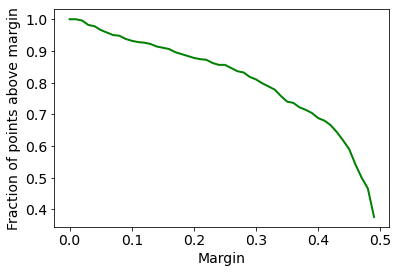

In [43]:
gammas = np.arange(0,0.5,0.01)
f = np.vectorize(lambda g: margin_counts(test_data, final_weights,g))
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color='green')
plt.xlabel('Margin', fontsize=14)
plt.ylabel('Fraction of points above margin', fontsize=14)
plt.show()

Next, we investigate a natural question: Are points `x` with larger margin more likely to be classified correctly?

To address this, we define a function **margin_errors** that computes the fraction of points with margin at least `gamma` that are misclassified.

**Task P7:** Implement the function `margin_errors` that computes the fraction of points with margin at least `gamma` that are misclassified. Copy the code and the output plot (i.e., visualization of the relationship between margin and error rate) to the solution file. What do you observe from the plot?

In [46]:
def margin_errors(feature_matrix, labels, weights, gamma):
## Return error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]

    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # labels: true labels y, a numpy vector of dimension n
    # weights: weight vector to start with, a numpy vector of dimension d+1
    # gamma: the margin value
    # Output:
    # error of predictions that lie in intervals [0, 0.5 - gamma) and (0.5 + gamma, 1]
    
    ## STUDENT: YOUR CODE HERE
    withinGamma = 0
    Wrong = 0
    
    for x in range(feature_matrix.shape[0]):
        n = feature_matrix[x]
        
        probPos = 1 / (1 + np.exp(-(1 * (np.dot(weights, n))))) 
        probNeg = 1 / (1 + np.exp(-(-1 * (np.dot(weights, n))))) 
        
        pred = 0
        if probPos > probNeg:
            pred = 1
        else:
            pred = -1
        
        prob = max(probPos, probNeg)
        
        if ((1 >= prob > gamma + 0.5) or (0 <= prob < gamma -0.5)):
            withinGamma += 1
            
            if pred != labels[x]:
                Wrong += 1
    return Wrong / withinGamma

    ## STUDENT: YOUR CODE ENDS

We now visualize the relationship between margin and error rate.

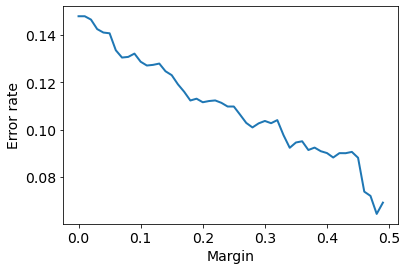

In [47]:
## Create grid of gamma values
gammas = np.arange(0, 0.5, 0.01)

## Compute margin_errors on test data for each value of g
f = np.vectorize(lambda g: margin_errors(test_data, test_labels,final_weights, g))

## Plot the result
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel('Error rate', fontsize=14)
plt.xlabel('Margin', fontsize=14)
plt.show()

## 4. Words with large influence

Finally, we attempt to partially **interpret** the logistic regression model.

Which words are most important in deciding whether a sentence is positive? As a first approximation to this, we simply take the words whose coefficients in $\theta$ have the largest positive values.

Likewise, we look at the words whose coefficients in $\theta$ have the most negative values, and we think of these as influential in negative predictions.

**Task P8:** Report the top 10 positive words (i.e., words with the largest positive coefficients of $\theta$) and the top 10 negative words (i.e., words with the most negative coefficients of $\theta$). 

In [49]:
## Convert vocabulary into a list:
## This is a list where the i-th entry corresponds to the 

vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])
print(vocab)

## STUDENT: YOUR CODE HERE
sortedList = final_weights.argsort()

pos = list()
neg = list()

for i in range(10):
    pos.append(vocab[sortedList[-(i + 1)]])
    neg.append(vocab[sortedList[i]])
    
print('Positive words are:\t' + str(pos))
print('Negative words are:\t' + str(neg))

## STUDENT: CODE ENDS

['aailiyah' 'abandoned' 'abhor' ... 'zero' 'zillion' 'zombie']
Positive words are:	['scratch', 'perfected', 'function', 'greatest', 'loved', 'awful', 'likes', 'nicest', 'lovely', 'deliciously']
Negative words are:	['disapppointment', 'poorly', 'wasted', 'sucker', 'arepas', 'disappointment', 'worth', 'dog', 'aversion', 'waste']


## 5. (Bonus question) Classifiers that can abstain

Suppose you are building a classifier, and can tolerate an error rate of at most some value `e`. Unfortunately, every classifier you try has a higher error than this. 

Therefore, you decide that the classifier is allowed to occasionally **abstain**: that is, to say *"don't know"*. When it actually makes a prediction, it must have error rate at most `e`. And subject to this constraint, it should abstain as infrequently as possible.

How would you build an abstaining classifier of this kind, starting from a logistic regression model? To get the bonus score, you need to show the following:

* A general description of the method
* Your code implementation
* A case study to show how you can use it in practice (including necessary plots)

In [ ]:
## STUDENT: YOUR CODE HERE


## STUDENT: CODE ENDS